In [2]:
import os
os.chdir('D:\\Gnan\\DA\\KMU\\Prediction-COVID-19')
from utils import *
from model import *
from trainer import *

from tqdm.notebook import tqdm
from torch.optim.adam import Adam
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import warnings
warnings.filterwarnings('ignore')

In [3]:
city = '서울'

path = 'Data/Variants/Infected/omicron/*.csv'
dic_files = Load_files.load_files(path, -14, -12)
data = dic_files[city]
data

,stdDay,incDec,22D_variants,23A_variants
0,2022-12-19,4191.0,2011.68,41.91
1,2022-12-20,18223.0,8747.04,182.23
2,2022-12-21,15564.0,7470.72,155.64
3,2022-12-22,13946.0,6694.08,139.46
4,2022-12-23,12414.0,5958.72,124.14
...,...,...,...,...
132,2023-04-30,3342.0,634.98,2138.88
133,2023-05-01,1112.0,211.28,711.68
134,2023-05-02,3963.0,752.97,2536.32
135,2023-05-03,5137.0,976.03,3287.68


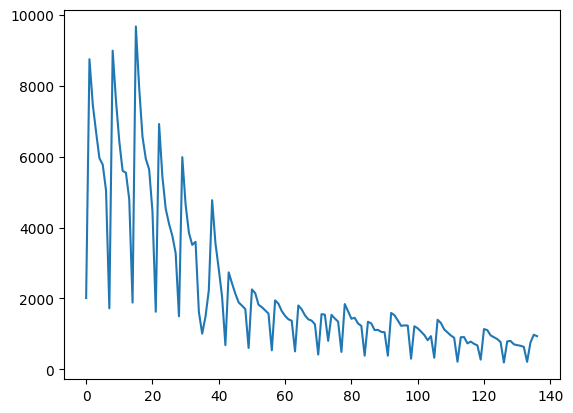

In [4]:
plt.plot(data['22D_variants'])

In [11]:
cities = ['강원', '경기', '경남', '경북', '광주', '대구', 
          '대전', '부산', '서울', '세종', '울산', '인천',
          '전남', '전북', '제주', '충남', '충북']

dic_hyperparameter = {}
for city in cities:
    path = f'hyperparameter/Infected/22D/{city}/*.pkl'
    files = glob.glob(path)
    hyperparameter = {}
    for file in files:
        hyperparameter[file[31:-4]] = load_hyperparameter(file)

    dic_hyperparameter[city] = hyperparameter

In [12]:
city_predicted = {}

for city in cities:
    
    dic_model = load_model_multiple(dic_hyperparameter, 'Infected', '22D', city)
    data = dic_files[city]
    df = Prepare_df.processing(data, 'stdDay', '22D_variants')

    x = df.iloc[:, 0:]
    y = df.iloc[:,:1]

    ms = MinMaxScaler()
    ss = StandardScaler()

    ss.fit(x)
    ms.fit(y)

    predicted_values = {}
    num_model = 0
    for name, state in dic_model.items():
        batch_size = 64
        if num_model < 6:
            x, y, x_ss, y_ms, train_loader, test_loader = Prepare_df.split_data(df, 68, 60, 1, batch_size, 'mto')
            label_y, predicted = predict_mto(state, df, x_ss, y_ms)
            predicted_values[name] = [label_y, predicted]
        else:
            x, y, x_ss, y_ms, train_loader, test_loader = Prepare_df.split_data(df, 62, 60, 7, batch_size, 'mtm')
            label_y, predicted, first_label_y, first_predicted, all_predicted = predict_mtm(state, df, x_ss, y_ms, 7, 0.5, device)
            predicted_values[name] = [label_y, predicted, first_label_y, first_predicted, all_predicted]

        num_model += 1
        
    city_predicted[city] = predicted_values

In [13]:
dic_best_model = {}

for city in cities:
    
    actual_data = city_predicted[city]['RNN'][0]
    rmse_min = np.inf
    num_model = 0

    for name, file in city_predicted[city].items():
        if num_model < 6:
            predicted_data = file[1]
        else:
            predicted_data = file[4]

        rmse_val = rmse(actual_data[-7:], predicted_data[-7:])
        if rmse_min > rmse_val:
            rmse_min = rmse_val
            best_model = name
            best_actual = actual_data
            best_predicted = predicted_data

        #print(city + ' :', rmse_val)
        #plotting(actual_data, predicted_data, 56)

        num_model += 1
    
    dic_best_model[city] = [best_model, rmse_val, best_actual, best_predicted]
    
    print(f'rmse가 가장 적은 모델 : {city}', best_model)
    df_predicted = pd.DataFrame()
    df_predicted = pd.DataFrame(np.concatenate([best_actual, best_predicted], axis = 1), columns = ['22D_origin', '22D_Predicted'])
    df_predicted.index = list(data['stdDay'][-1*len(best_actual):])
    df_predicted.to_csv(f'Data/Predicted/Variants/Infected/{city}/22D_{best_model}.csv')

rmse가 가장 적은 모델 : 강원 LSTM
rmse가 가장 적은 모델 : 경기 RNN
rmse가 가장 적은 모델 : 경남 seq2seq_LSTM
rmse가 가장 적은 모델 : 경북 GRU
rmse가 가장 적은 모델 : 광주 seq2seq_GRU
rmse가 가장 적은 모델 : 대구 BiRNN
rmse가 가장 적은 모델 : 대전 BiGRU
rmse가 가장 적은 모델 : 부산 GRU
rmse가 가장 적은 모델 : 서울 seq2seq_BiGRU
rmse가 가장 적은 모델 : 세종 BiLSTM
rmse가 가장 적은 모델 : 울산 BiLSTM
rmse가 가장 적은 모델 : 인천 BiRNN
rmse가 가장 적은 모델 : 전남 seq2seq_LSTM
rmse가 가장 적은 모델 : 전북 BiGRU
rmse가 가장 적은 모델 : 제주 BiGRU
rmse가 가장 적은 모델 : 충남 RNN
rmse가 가장 적은 모델 : 충북 GRU


강원 best model : LSTM
rmse : 12.02223371065272


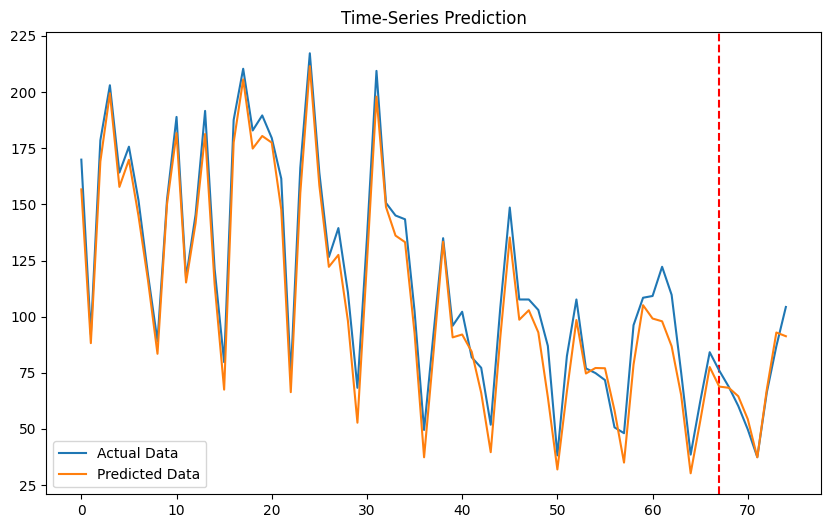

경기 best model : RNN
rmse : 86.79608038565163


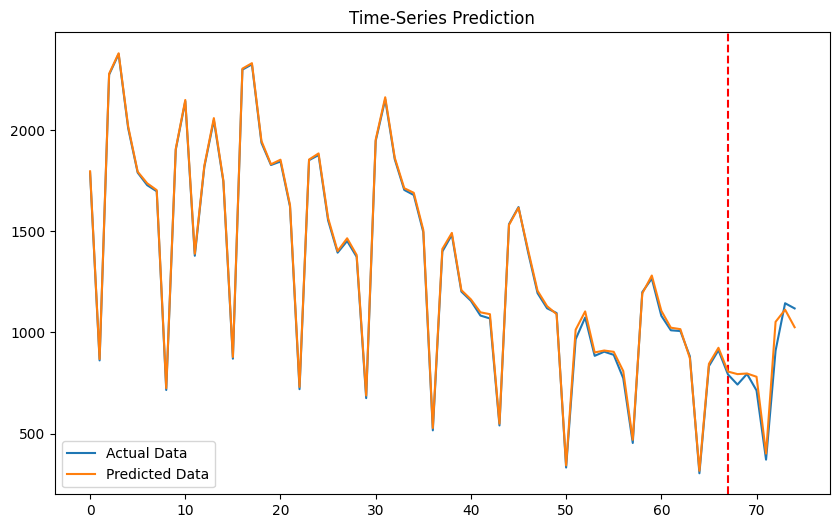

경남 best model : seq2seq_LSTM
rmse : 40.16195393584969


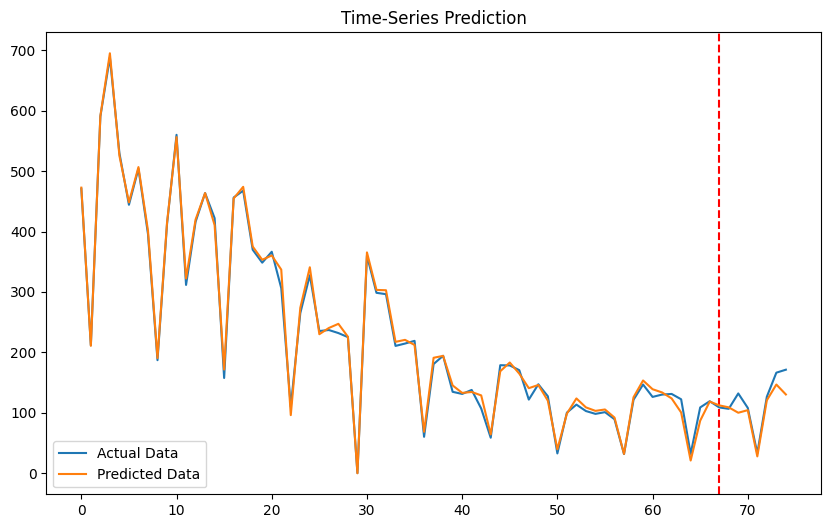

경북 best model : GRU
rmse : 22.07766539573811


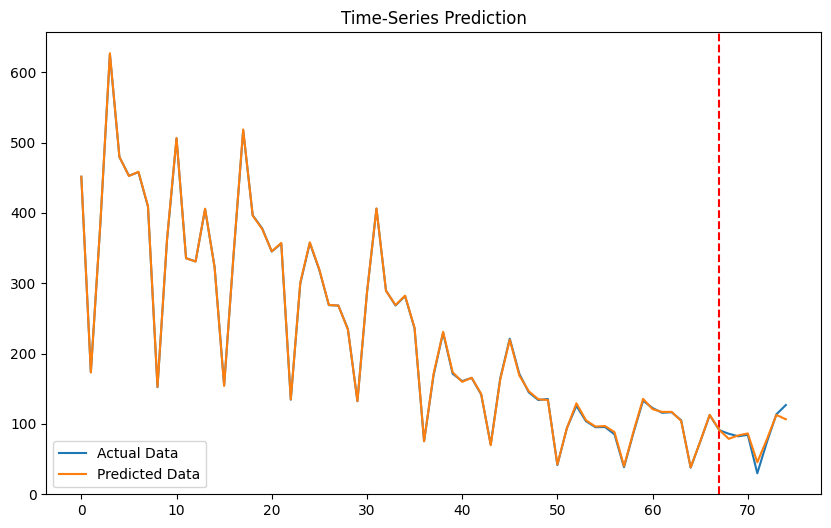

광주 best model : seq2seq_GRU
rmse : 12.663253993701002


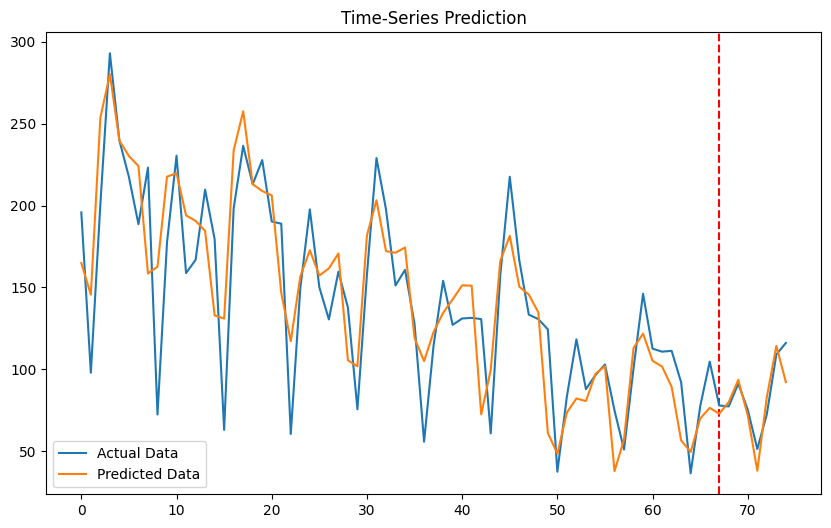

대구 best model : BiRNN
rmse : 20.648900835465568


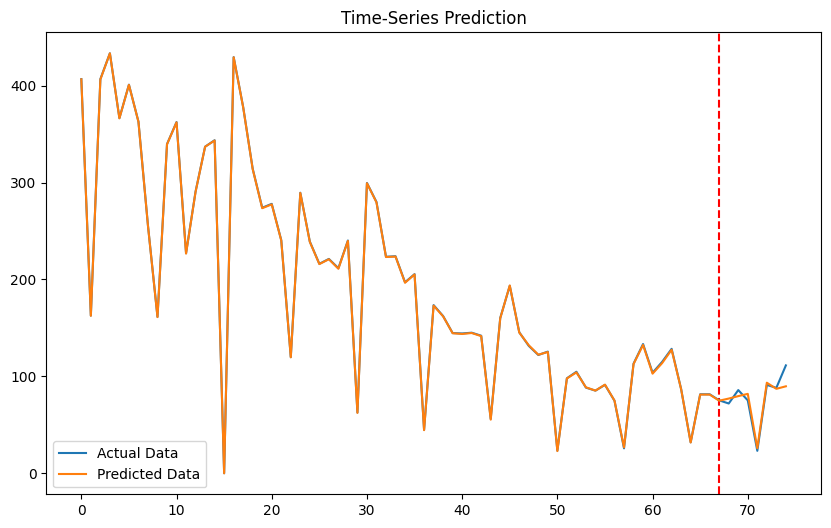

대전 best model : BiGRU
rmse : 32.70863210618586


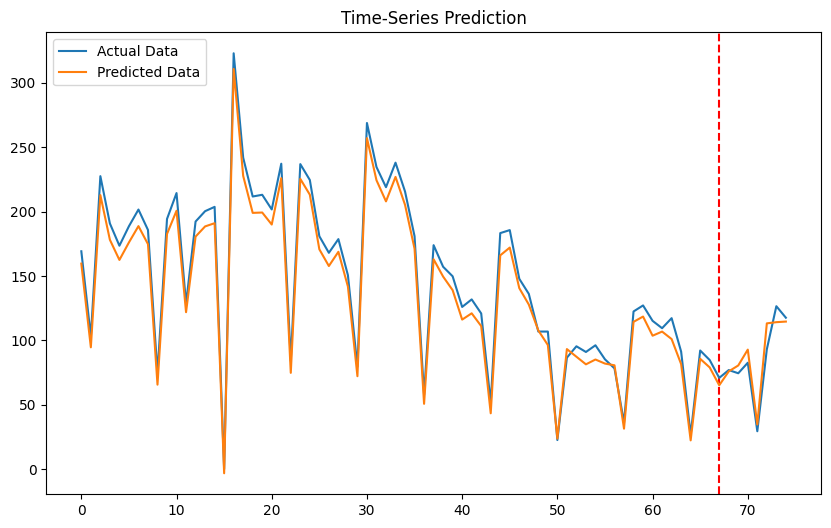

부산 best model : GRU
rmse : 33.81171476964844


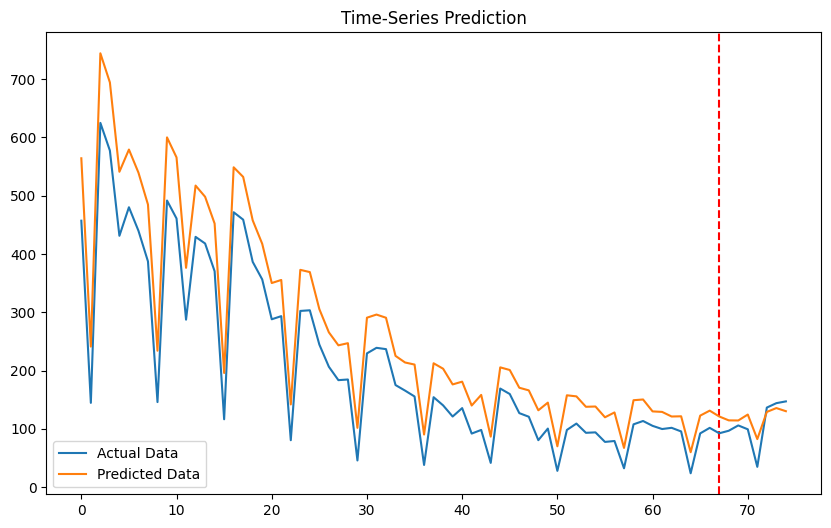

서울 best model : seq2seq_BiGRU
rmse : 64.38661530526939


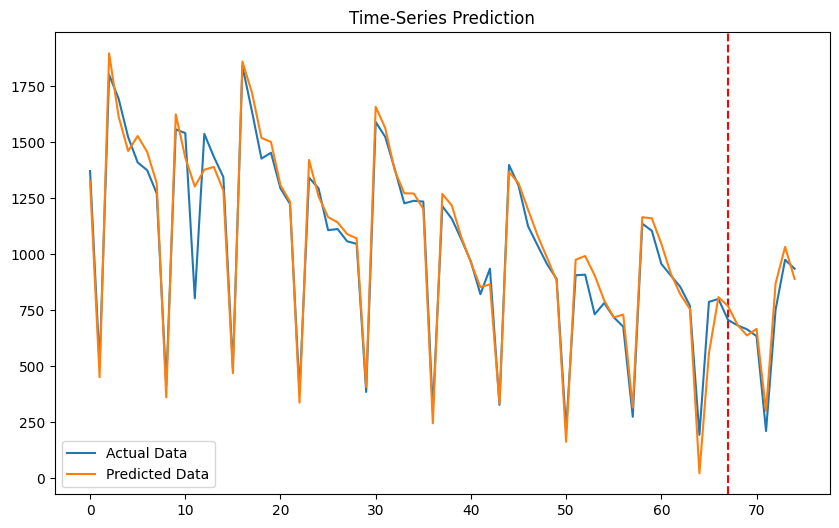

세종 best model : BiLSTM
rmse : 9.399394125384699


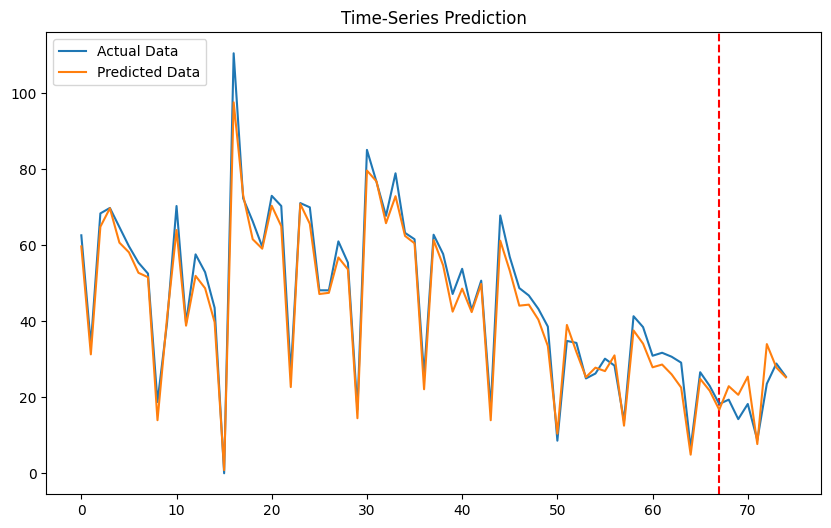

울산 best model : BiLSTM
rmse : 11.868218664054538


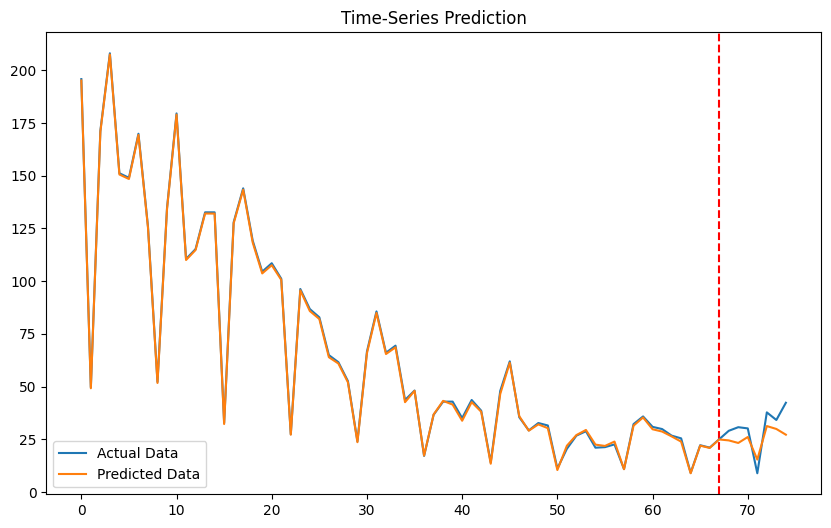

인천 best model : BiRNN
rmse : 29.080293192270904


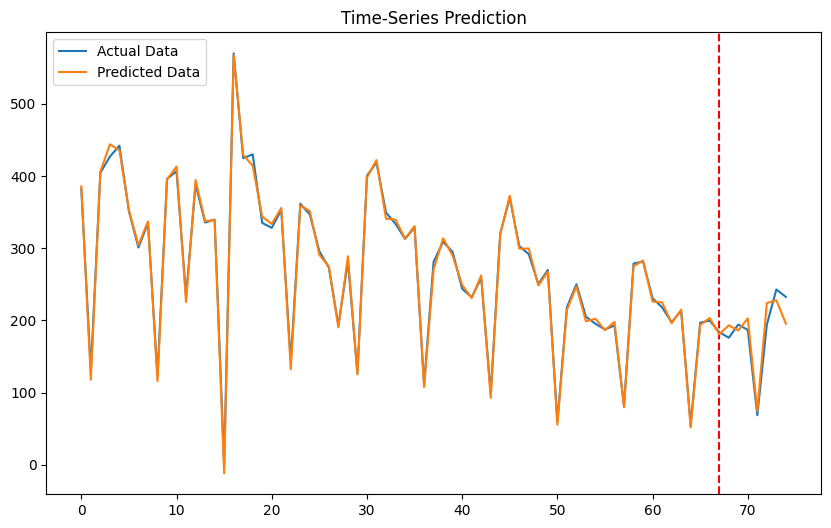

전남 best model : seq2seq_LSTM
rmse : 17.742111817319866


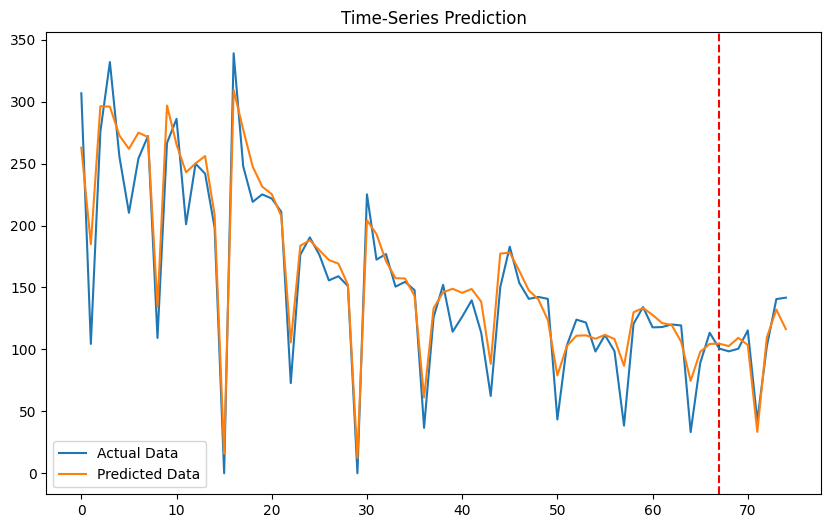

전북 best model : BiGRU
rmse : 28.19149258032022


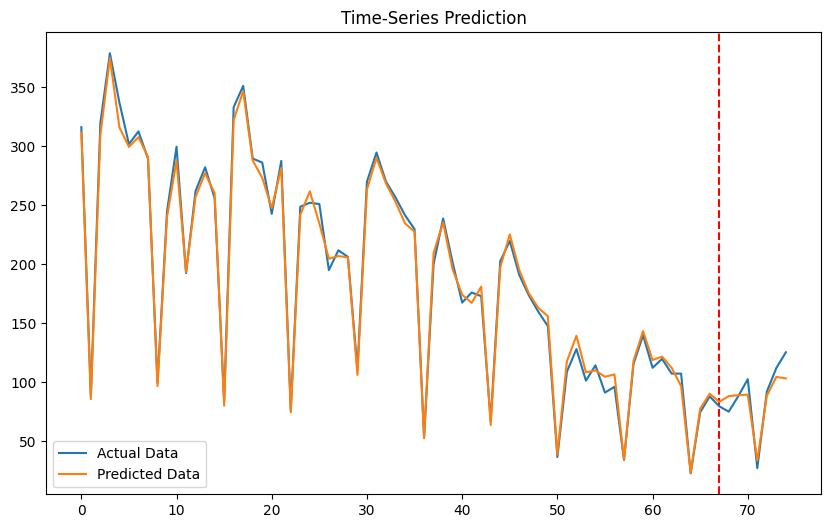

제주 best model : BiGRU
rmse : 6.31735586602017


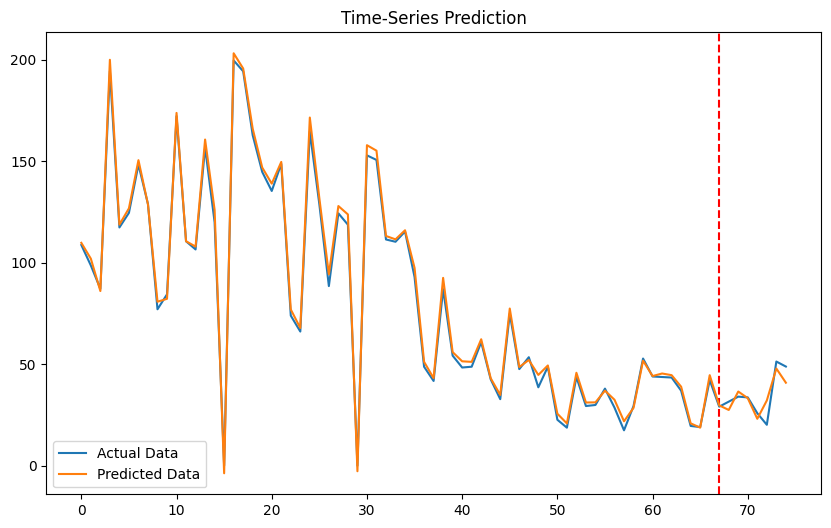

충남 best model : RNN
rmse : 11.779592058407626


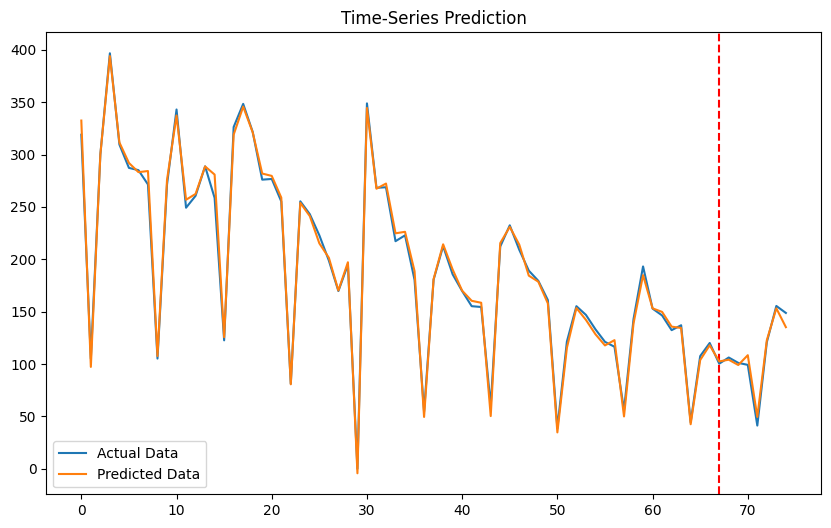

충북 best model : GRU
rmse : 18.81992900579604


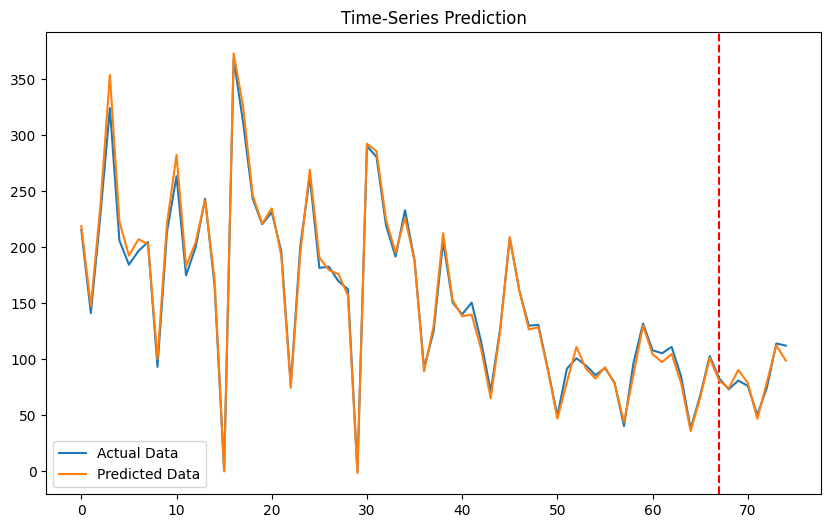

In [20]:
for city in cities:
    print(f'{city} best model : {dic_best_model[city][0]}')
    print(f'rmse : {dic_best_model[city][1]}')
    plotting(dic_best_model[city][2], dic_best_model[city][3], 67)